# SWB Regression Pipeline - Beta Power 
- Single Electrode Trial Averaged Regressions with Permutation Statistics
- Robust regression bdi ~ cpe regression coefficients for each ROI 
- ROI split mixed effects regressions (currently depreciated)

Created: 07/30/24 \
*Updated: 08/22/2024 with new regression dfs from 08/22/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2



In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)



08222024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *



In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [ ]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [ ]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [8]:
beta_df = pd.read_csv(f'{save_dir}beta_master_df.csv')
band = 'beta'
beta_df.subj_id.unique()



array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [9]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [10]:
roi_reref_labels_master_df.roi.value_counts()



dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: roi, dtype: int64

In [25]:
# #### filter df by rois with electrode counts >= 50 *** updated to >15
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
# ).values>=20].tolist()

# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     
# keep_rois.del(['thalamus','sts','temporal'])
# keep_rois = keep_rois
keep_rois

['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [26]:
# ####### NEW DATA FRAME 
beta_reg_df = beta_df.copy()
beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(keep_rois)]
# len(beta_reg_df)



# Test Single Electrode Regressions 

In [27]:
elec_col    = 'unique_reref_ch'
main_var    = 'decisionCPE'
reg_formula = 'band_pow~GambleChoice+TotalProfit+decisionCPE'
n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(beta_reg_df,reg_formula,elec_col, 
                                                            main_var,n_permutations)

Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3481.73it/s]


In [28]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'decisionCPE']

In [29]:
results = single_elec_permutation_results(results_dict,beta_reg_df,save_vars)
results



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.030883,-0.048833,0.024836,0.030278,-0.003360,0.000667,...,0.022497,0.021384,2.092681,-2.092681,1.095549,1.397127,0.036378,0.036378,0.273276,0.162375
1,MS002_lacas2-lacas3,MS002,acc,14,-0.010171,0.017089,0.019667,0.041767,0.001377,0.000397,...,0.025164,0.025187,-0.590903,0.590903,0.749768,1.621574,0.554586,0.554586,0.453394,0.104895
2,MS002_lacas3-lacas4,MS002,acc,14,0.010854,-0.016153,0.012513,0.045390,-0.000546,0.000326,...,0.022789,0.023113,0.660057,-0.660057,0.563319,1.907171,0.509217,0.509217,0.573218,0.056498
3,MS002_lacas4-lacas5,MS002,acc,14,0.002168,-0.016207,-0.007460,0.041141,-0.009393,0.000505,...,0.020449,0.020549,0.731555,-0.731555,-0.390753,2.038809,0.464440,0.464440,0.695979,0.041469
4,MS002_lacas5-lacas6,MS002,acc,14,-0.008841,0.017567,-0.006853,-0.003911,0.003206,0.000152,...,0.021482,0.021100,-0.736681,0.736681,-0.273745,-0.176125,0.461317,0.461317,0.784280,0.860196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,DA039_rpins1-rpins2,DA039,pins,22,0.006150,0.000627,-0.006567,0.023253,0.006444,-0.000138,...,0.025073,0.025312,-0.030028,0.030028,-0.259367,0.944402,0.976045,0.976045,0.795352,0.344964
1184,DA039_rpins2-rpins3,DA039,pins,22,0.012924,0.037311,0.002998,0.014782,0.027255,-0.000072,...,0.026907,0.026937,-1.333300,1.333300,0.142622,0.506412,0.182433,0.182433,0.886588,0.612568
1185,DA039_rpins3-rpins4,DA039,pins,22,-0.005030,-0.032606,-0.054730,0.044405,-0.017848,0.000831,...,0.030681,0.031100,1.098347,-1.098347,-1.821418,1.390424,0.272053,0.272053,0.068543,0.164400
1186,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.123066,0.017559,0.011615,0.056642,-0.116166,-0.000440,...,0.044756,0.045825,-0.385835,0.385835,0.249802,1.270709,0.699619,0.699619,0.802741,0.203832


In [30]:
results.columns



Index(['unique_elec_id', 'subj_id', 'roi', 'bdi',
       'Original_Estimate_Intercept', 'Original_Estimate_GambleChoice[T.safe]',
       'Original_Estimate_TotalProfit', 'Original_Estimate_decisionCPE',
       'Permuted_Mean_Intercept', 'Permuted_Mean_GambleChoice[T.safe]',
       'Permuted_Mean_TotalProfit', 'Permuted_Mean_decisionCPE',
       'Permuted_Std_Intercept', 'Permuted_Std_GambleChoice[T.safe]',
       'Permuted_Std_TotalProfit', 'Permuted_Std_decisionCPE',
       'Z_Score_Intercept', 'Z_Score_GambleChoice[T.safe]',
       'Z_Score_TotalProfit', 'Z_Score_decisionCPE', 'P_Value_Intercept',
       'P_Value_GambleChoice[T.safe]', 'P_Value_TotalProfit',
       'P_Value_decisionCPE'],
      dtype='object')

In [31]:
# # create a binary pickle file 
pickle.dump(results,
            open(f'{save_dir}single_elec_regression_{band}_{reg_formula}_{date}.pkl',"wb"))



In [45]:
sig_data = results[results.P_Value_decisionCPE < 0.05]
sig_data



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
3,MS002_lacas4-lacas5,MS002,acc,14,0.002168,-0.016207,-0.007460,0.041141,-0.009393,0.000505,...,0.020449,0.020549,0.731555,-0.731555,-0.390753,2.038809,0.464440,0.464440,0.695979,0.041469
15,MS002_laims4-laims5,MS002,ains,14,-0.007378,0.047009,0.043292,0.065644,0.025761,-0.000895,...,0.030262,0.031009,-1.472270,1.472270,1.439693,2.103209,0.140948,0.140948,0.149954,0.035448
51,MS002_racas6-racas7,MS002,dmpfc,14,0.090297,-0.078379,-0.000139,-0.057667,0.036307,-0.000333,...,0.029636,0.029035,2.431976,-2.431976,-0.015588,-1.973616,0.015017,0.015017,0.987563,0.048425
52,MS002_racas7-racas8,MS002,dmpfc,14,0.128225,-0.127799,0.014455,-0.067314,0.039644,0.000250,...,0.033899,0.032560,3.651408,-3.651408,0.401669,-2.036471,0.000261,0.000261,0.687927,0.041703
58,MS002_raims1-raims2,MS002,ains,14,0.112480,-0.115058,0.034586,0.097877,0.033138,-0.000365,...,0.037336,0.039210,2.704836,-2.704836,0.937575,2.538266,0.006834,0.006834,0.348463,0.011140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,DA026_lhh2-lhh3,DA026,hpc,19,-0.081116,0.026060,-0.055078,-0.102806,-0.066962,-0.000086,...,0.034612,0.034368,-0.762088,0.762088,-1.555950,-2.969845,0.446008,0.446008,0.119720,0.002979
1144,DA037_rmins1-rmins2,DA037,pins,4,-0.134143,0.055278,-0.020561,0.089573,-0.121356,0.000935,...,0.027844,0.028663,-1.609116,1.609116,-0.720858,3.118726,0.107591,0.107591,0.470997,0.001816
1180,DA039_rof9-rof10,DA039,dlpfc,22,-0.086829,0.009231,0.053648,0.091305,-0.083250,-0.000107,...,0.041774,0.042225,-0.234677,0.234677,1.296474,2.135743,0.814459,0.814459,0.194812,0.032700
1182,DA039_rof11-rof12,DA039,dlpfc,22,-0.174226,-0.050734,0.006831,0.084149,-0.194063,0.001015,...,0.042863,0.041337,1.193547,-1.193547,0.128357,2.043990,0.232655,0.232655,0.897866,0.040955


In [46]:
sig_data.roi.value_counts()



acc      23
dmpfc    18
ofc      16
dlpfc    12
ains      9
pins      7
amy       5
vlpfc     5
hpc       5
Name: roi, dtype: int64

In [34]:
sig_data.roi.unique()



array(['acc', 'ains', 'dmpfc', 'amy', 'dlpfc', 'ofc', 'pins', 'vlpfc',
       'hpc'], dtype=object)

In [35]:
bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']


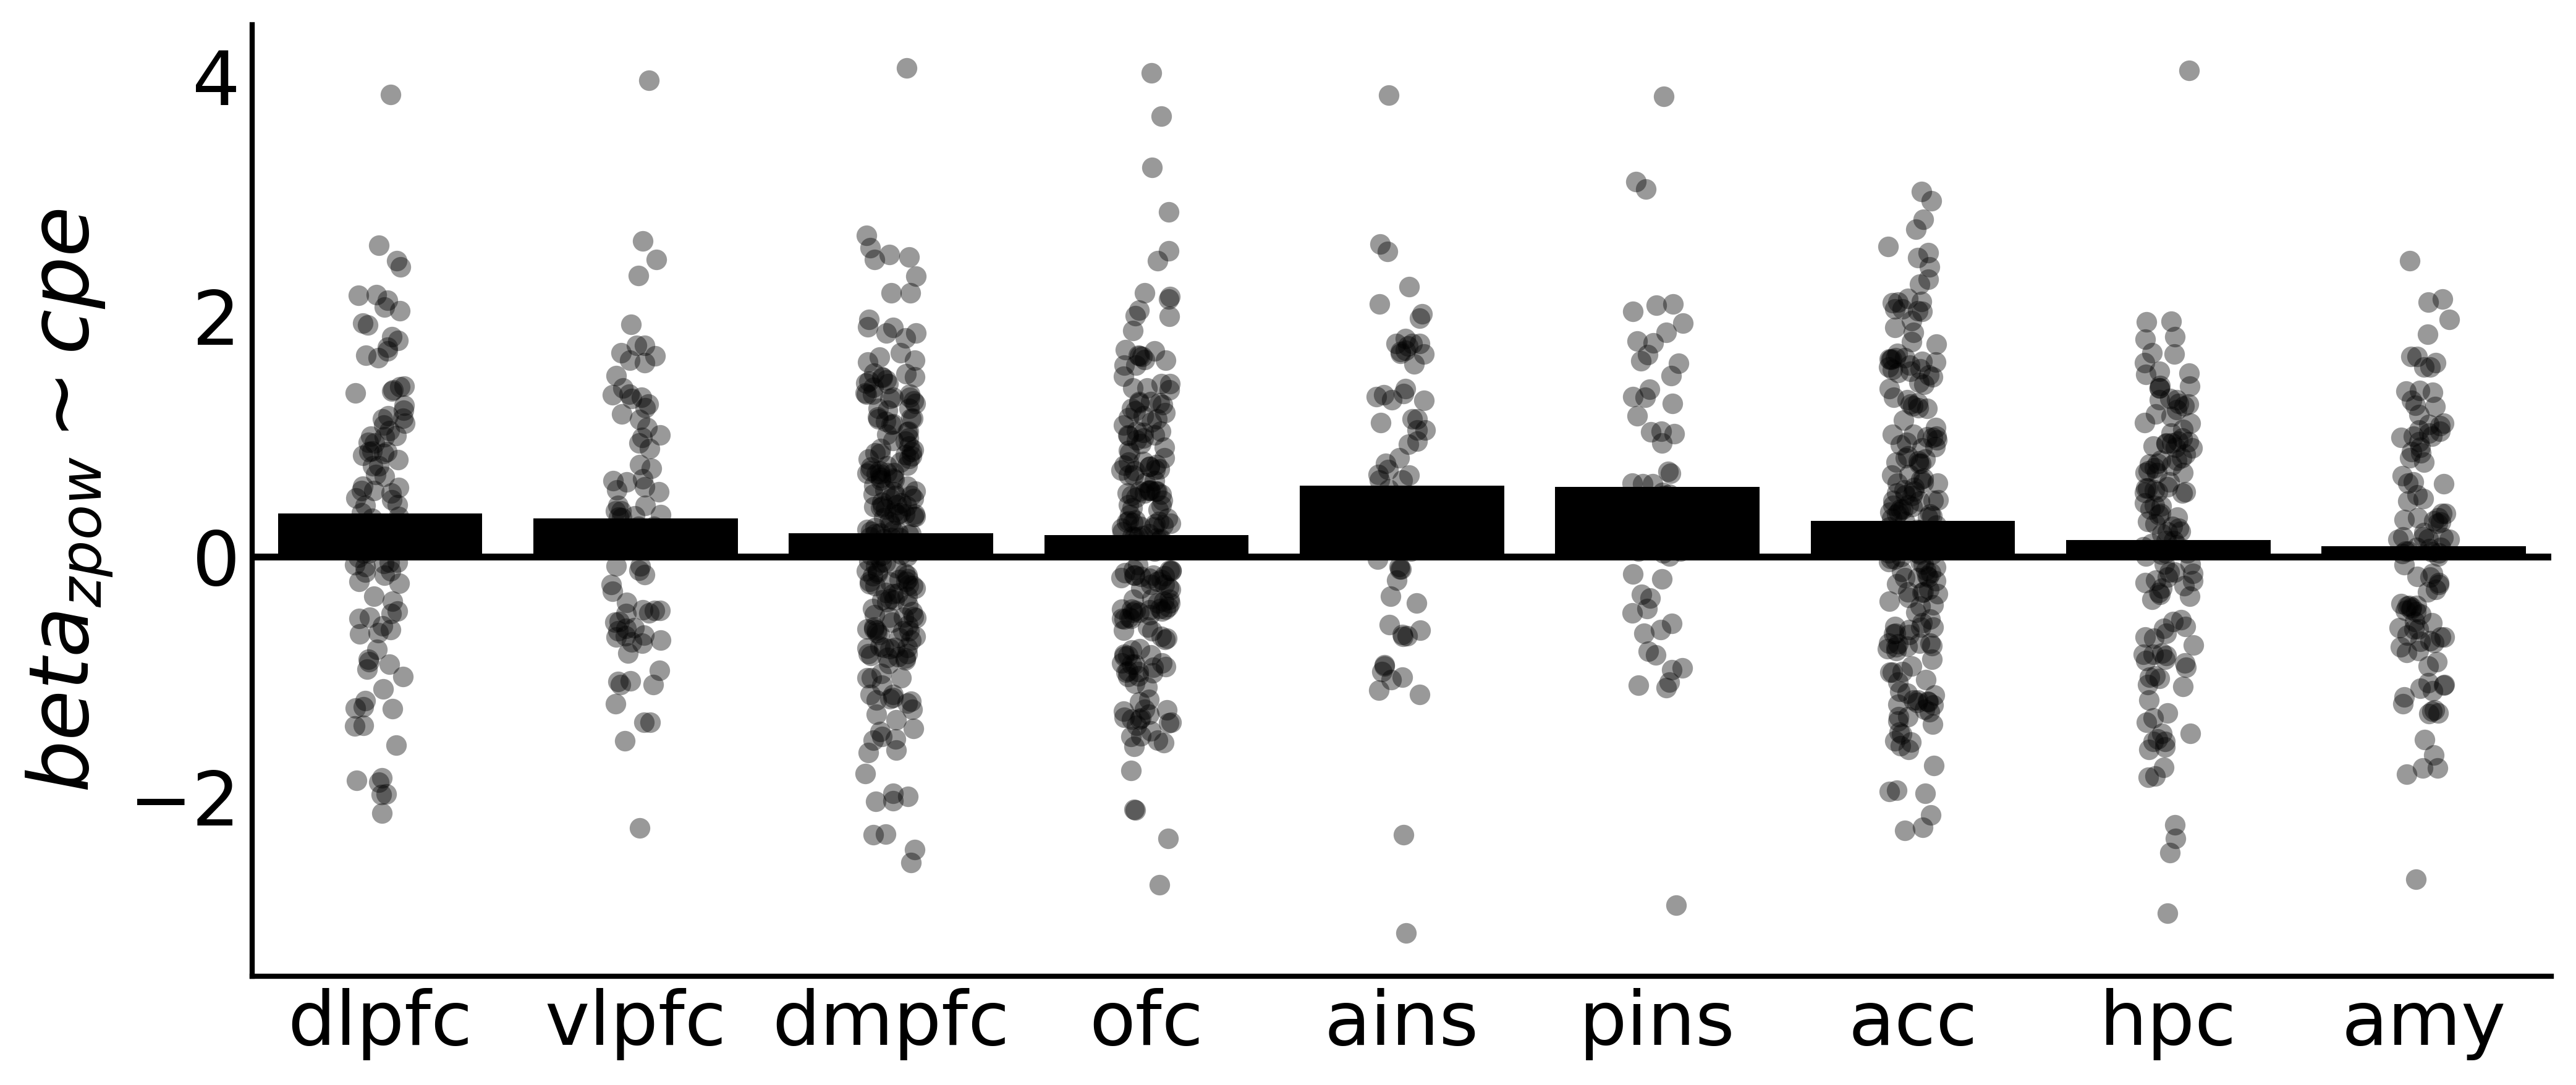

In [36]:
ylabel = fr'${band}_{{zpow}} \sim cpe$'
fig_save_dir = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/results/single-electrode-regressions/'
fig_id = f'{band}_single_elec_roi_barplot.pdf'


plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_dir,fig_id=fig_id,dpi=400)



In [37]:
results.to_csv(f'{fig_save_dir}{band}_single_elec_perm_results.csv')

In [38]:
results.groupby('roi').agg('mean')['Z_Score_decisionCPE'][bar_order]



roi
dlpfc    0.358447
vlpfc    0.318515
dmpfc    0.192091
ofc      0.181016
ains     0.592154
pins     0.580020
acc      0.296884
hpc      0.138205
amy      0.085828
Name: Z_Score_decisionCPE, dtype: float64

In [39]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res


,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.030883,-0.048833,0.024836,0.030278,-0.003360,0.000667,...,0.022497,0.021384,2.092681,-2.092681,1.095549,1.397127,0.036378,0.036378,0.273276,0.162375
1,MS002_lacas2-lacas3,MS002,acc,14,-0.010171,0.017089,0.019667,0.041767,0.001377,0.000397,...,0.025164,0.025187,-0.590903,0.590903,0.749768,1.621574,0.554586,0.554586,0.453394,0.104895
2,MS002_lacas3-lacas4,MS002,acc,14,0.010854,-0.016153,0.012513,0.045390,-0.000546,0.000326,...,0.022789,0.023113,0.660057,-0.660057,0.563319,1.907171,0.509217,0.509217,0.573218,0.056498
3,MS002_lacas4-lacas5,MS002,acc,14,0.002168,-0.016207,-0.007460,0.041141,-0.009393,0.000505,...,0.020449,0.020549,0.731555,-0.731555,-0.390753,2.038809,0.464440,0.464440,0.695979,0.041469
4,MS002_lacas5-lacas6,MS002,acc,14,-0.008841,0.017567,-0.006853,-0.003911,0.003206,0.000152,...,0.021482,0.021100,-0.736681,0.736681,-0.273745,-0.176125,0.461317,0.461317,0.784280,0.860196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,DA039_rpins1-rpins2,DA039,pins,22,0.006150,0.000627,-0.006567,0.023253,0.006444,-0.000138,...,0.025073,0.025312,-0.030028,0.030028,-0.259367,0.944402,0.976045,0.976045,0.795352,0.344964
1184,DA039_rpins2-rpins3,DA039,pins,22,0.012924,0.037311,0.002998,0.014782,0.027255,-0.000072,...,0.026907,0.026937,-1.333300,1.333300,0.142622,0.506412,0.182433,0.182433,0.886588,0.612568
1185,DA039_rpins3-rpins4,DA039,pins,22,-0.005030,-0.032606,-0.054730,0.044405,-0.017848,0.000831,...,0.030681,0.031100,1.098347,-1.098347,-1.821418,1.390424,0.272053,0.272053,0.068543,0.164400
1186,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.123066,0.017559,0.011615,0.056642,-0.116166,-0.000440,...,0.044756,0.045825,-0.385835,0.385835,0.249802,1.270709,0.699619,0.699619,0.802741,0.203832


In [40]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
#     fe_results['rho'][fe_results.roi==roi]   = rho
#     fe_results['rho_p'][fe_results.roi==roi] = rho_p
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:


    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)




In [41]:
agg_single_results = single_elec_res.groupby('roi').agg('mean')[['Z_Score_decisionCPE']].copy()

agg_single_results


,Z_Score_decisionCPE
roi,
acc,0.296884
ains,0.592154
amy,0.085828
dlpfc,0.358447
dmpfc,0.192091
hpc,0.138205
ofc,0.181016
pins,0.580020
vlpfc,0.318515


In [42]:
single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_decisionCPE'] = agg_single_results.Z_Score_decisionCPE
single_rho_data[['Z_Score_decisionCPE','rho','rho_p']]



,Z_Score_decisionCPE,rho,rho_p
roi,,,
acc,0.296884,-0.133218,0.0648
dmpfc,0.192091,-0.009740,0.8845
amy,0.085828,-0.011364,0.9049
ains,0.592154,-0.283165,0.0167
vlpfc,0.318515,-0.277458,0.0116
hpc,0.138205,-0.094664,0.2748
ofc,0.181016,-0.209447,0.0028
pins,0.580020,0.048131,0.7150
dlpfc,0.358447,-0.212535,0.0280


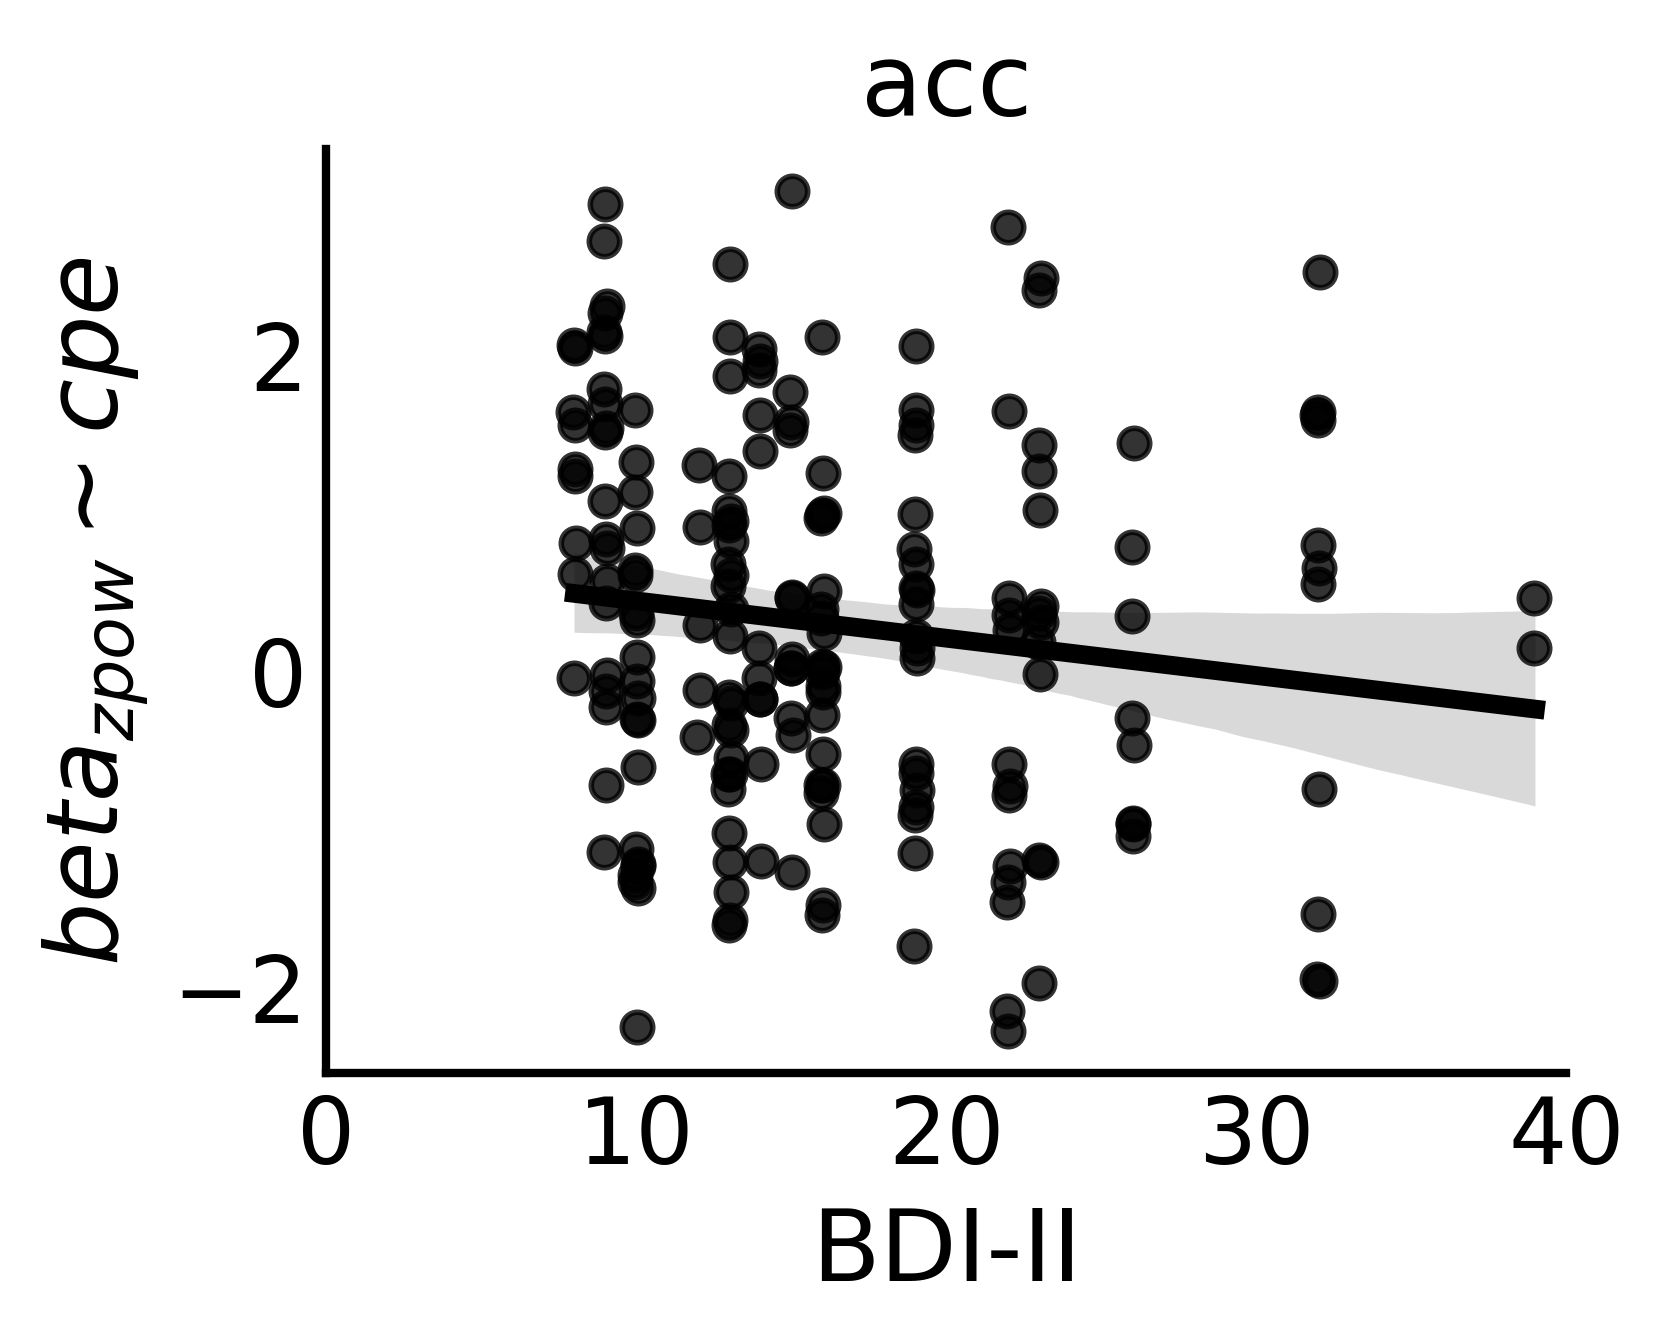

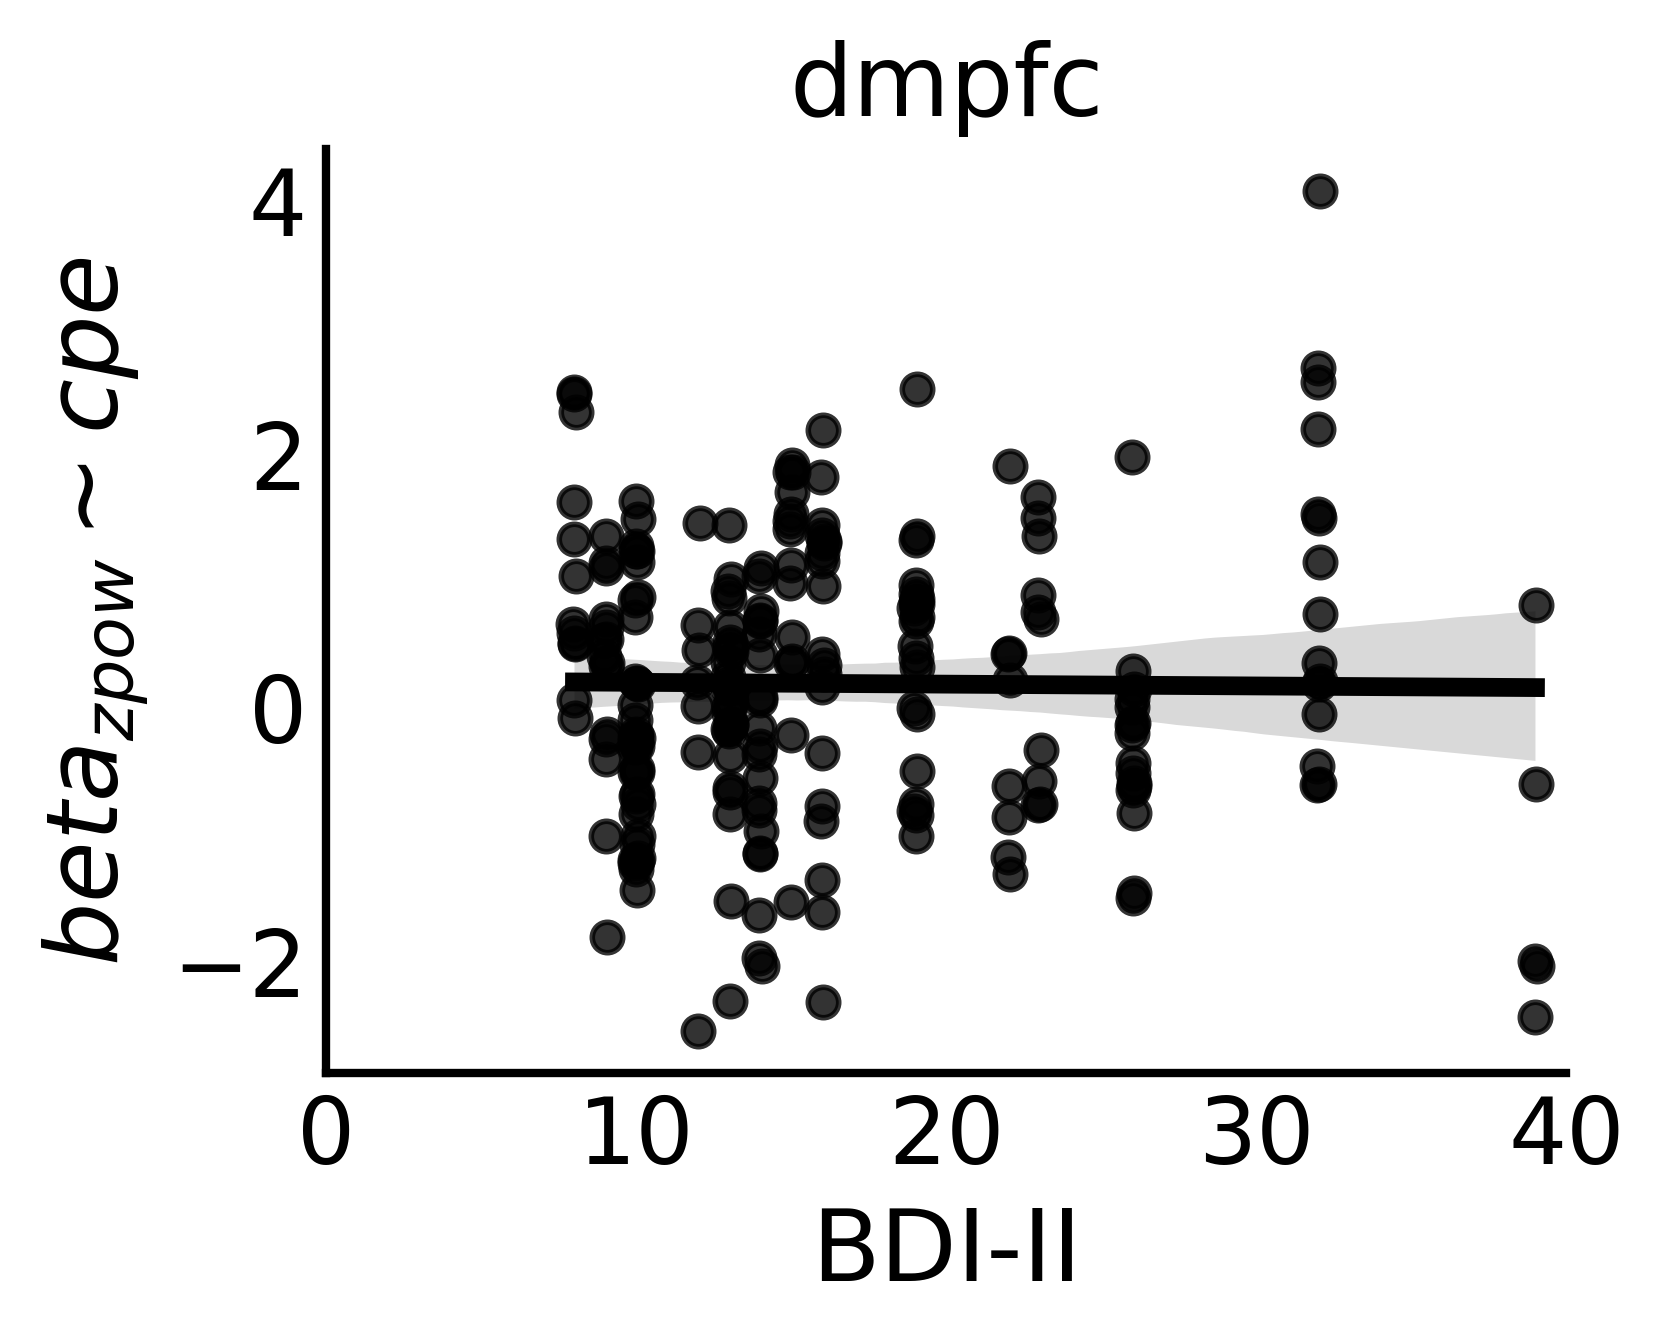

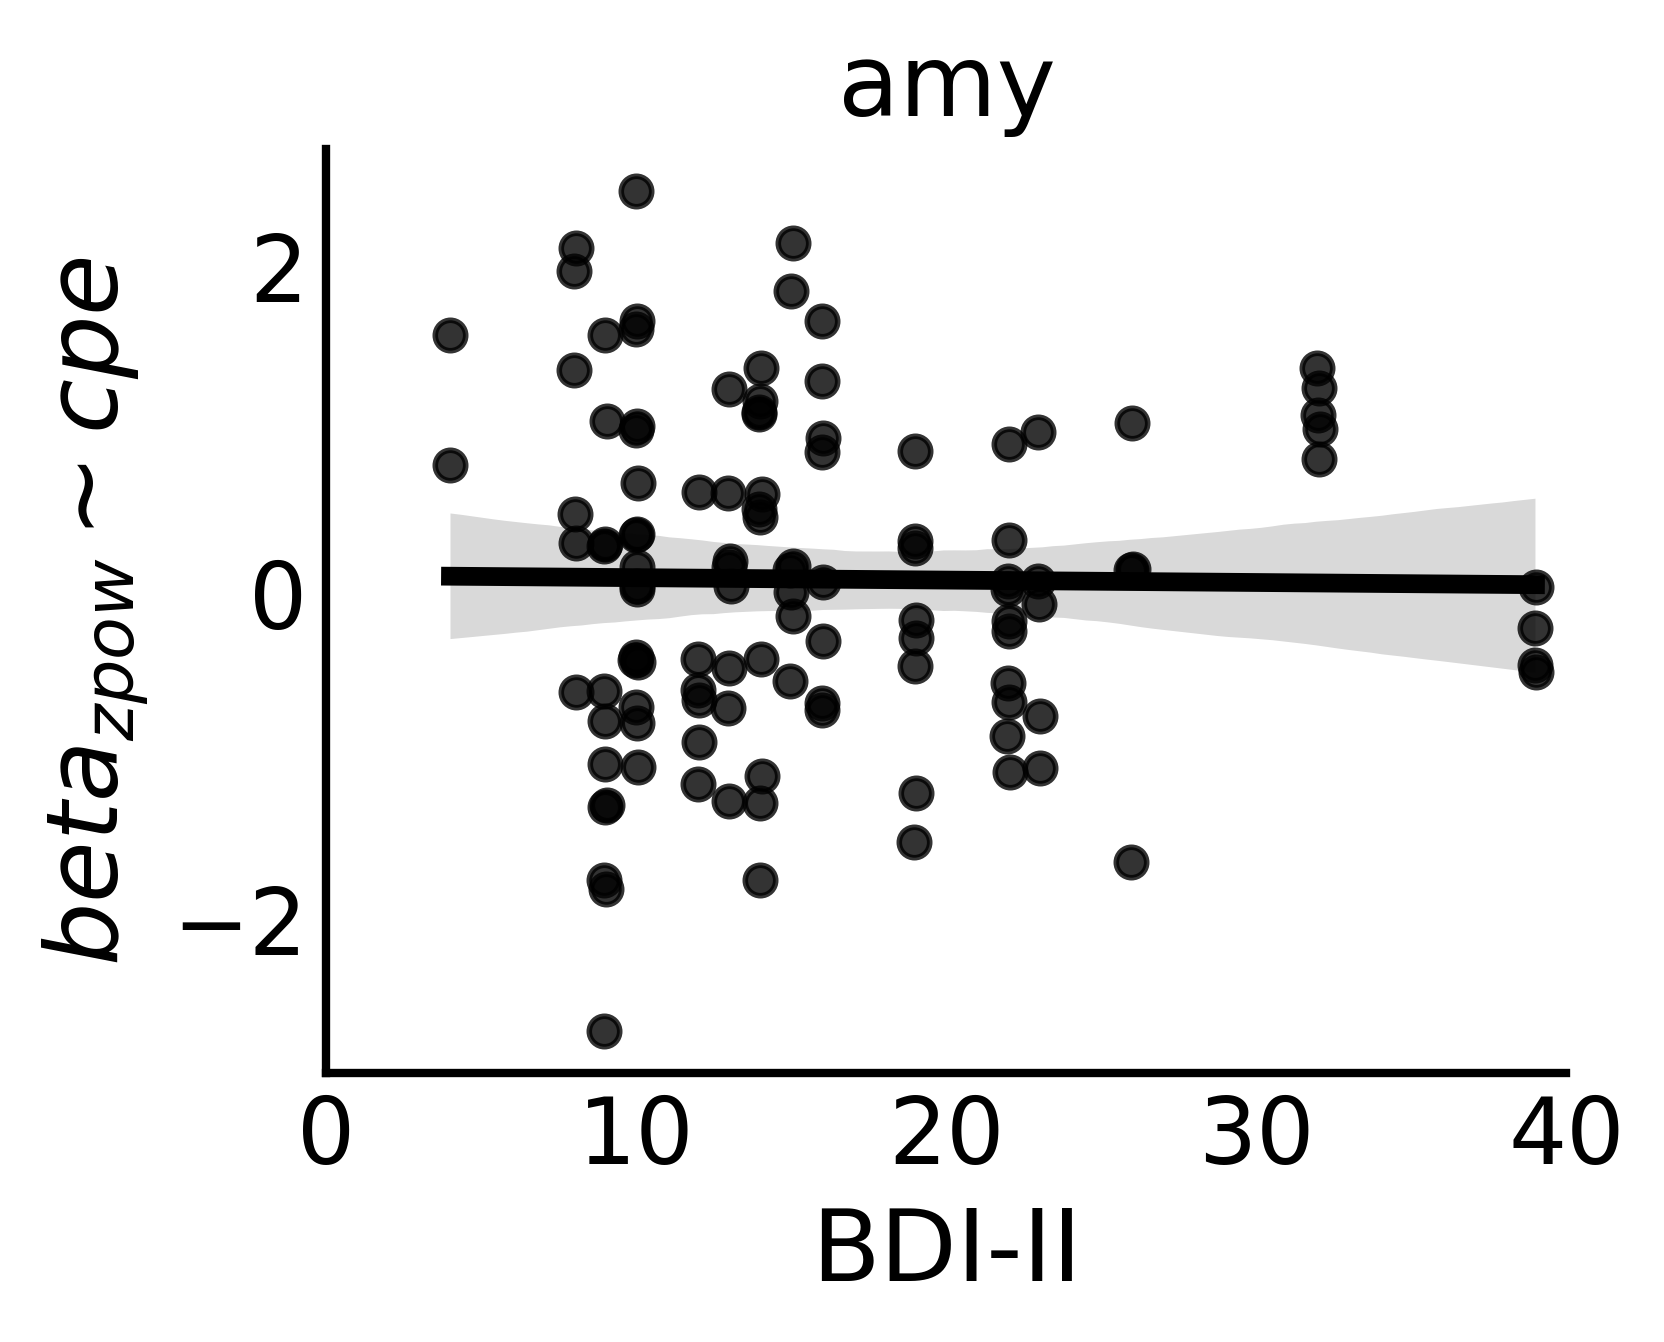

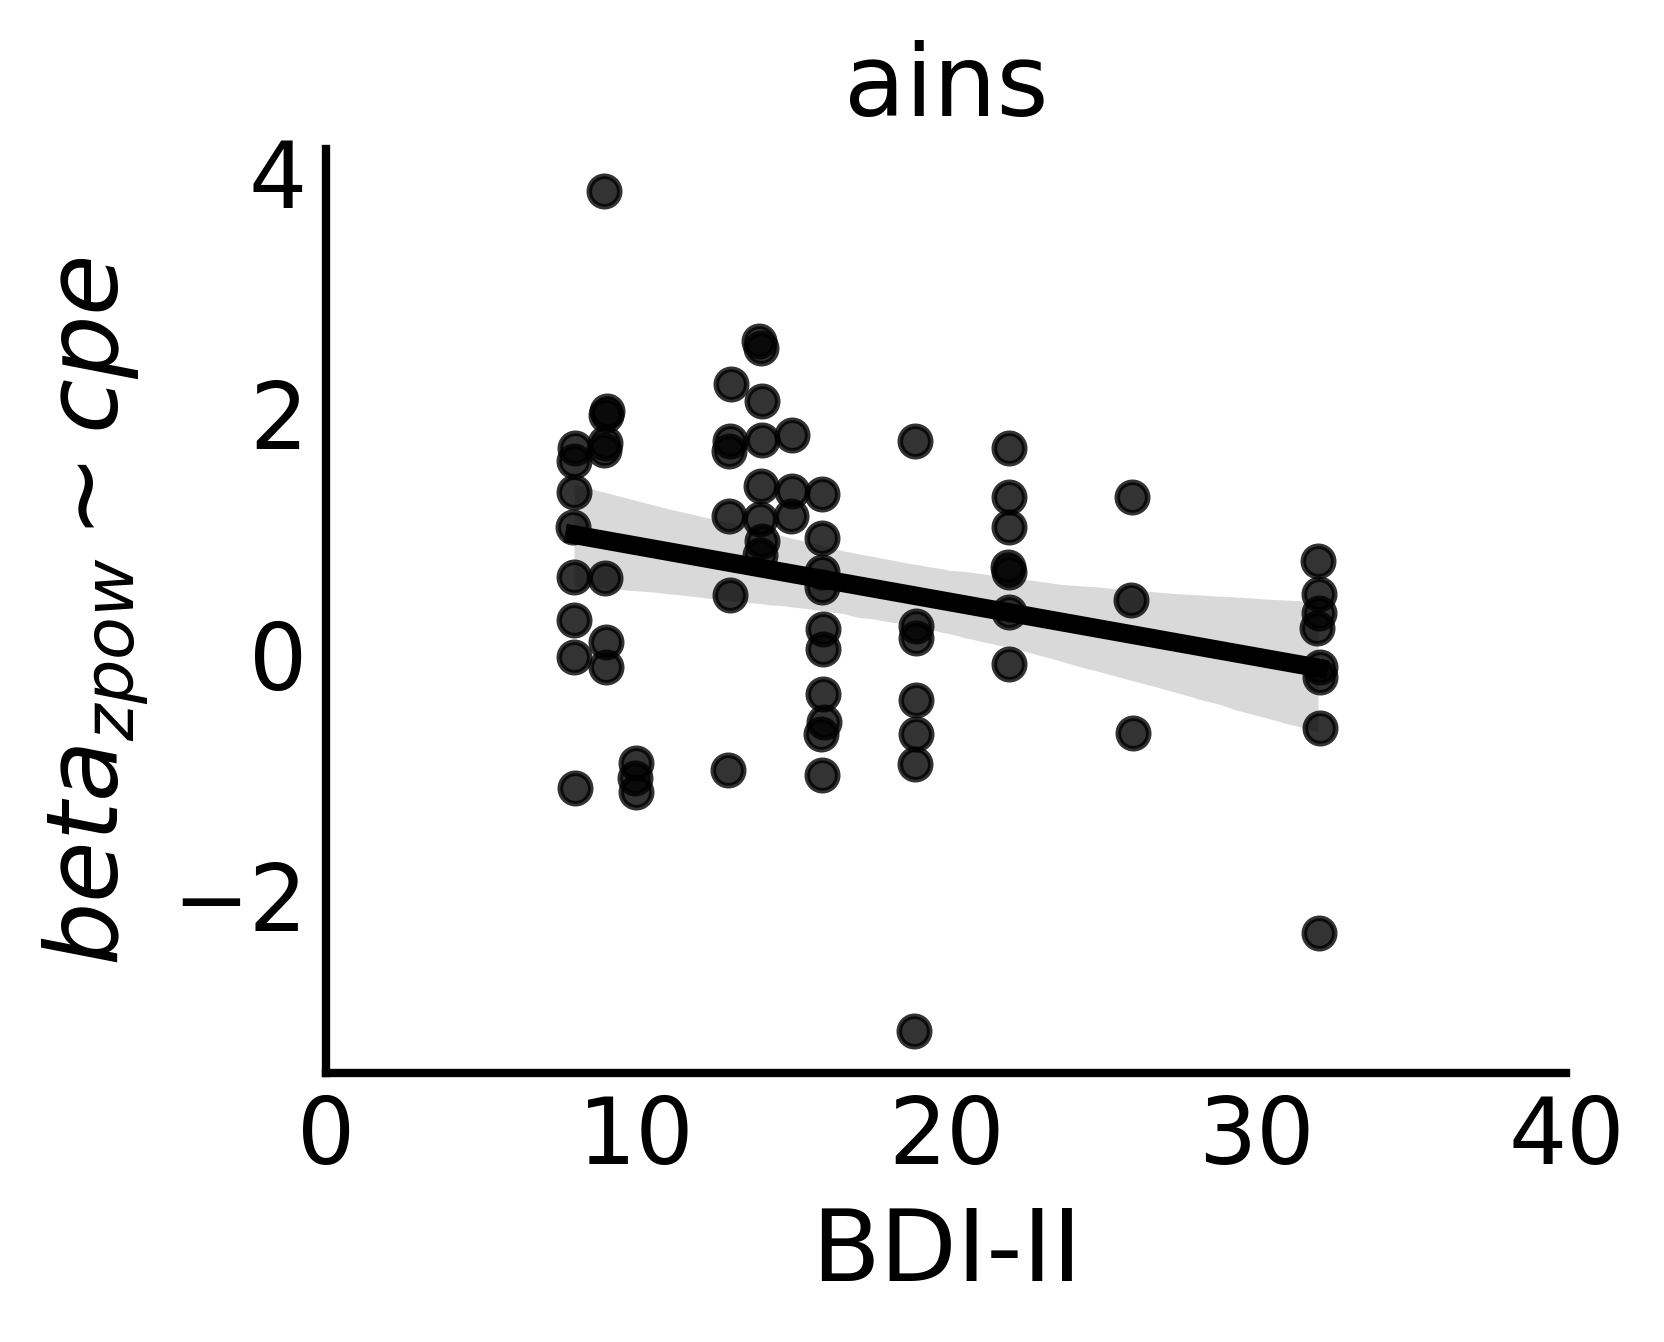

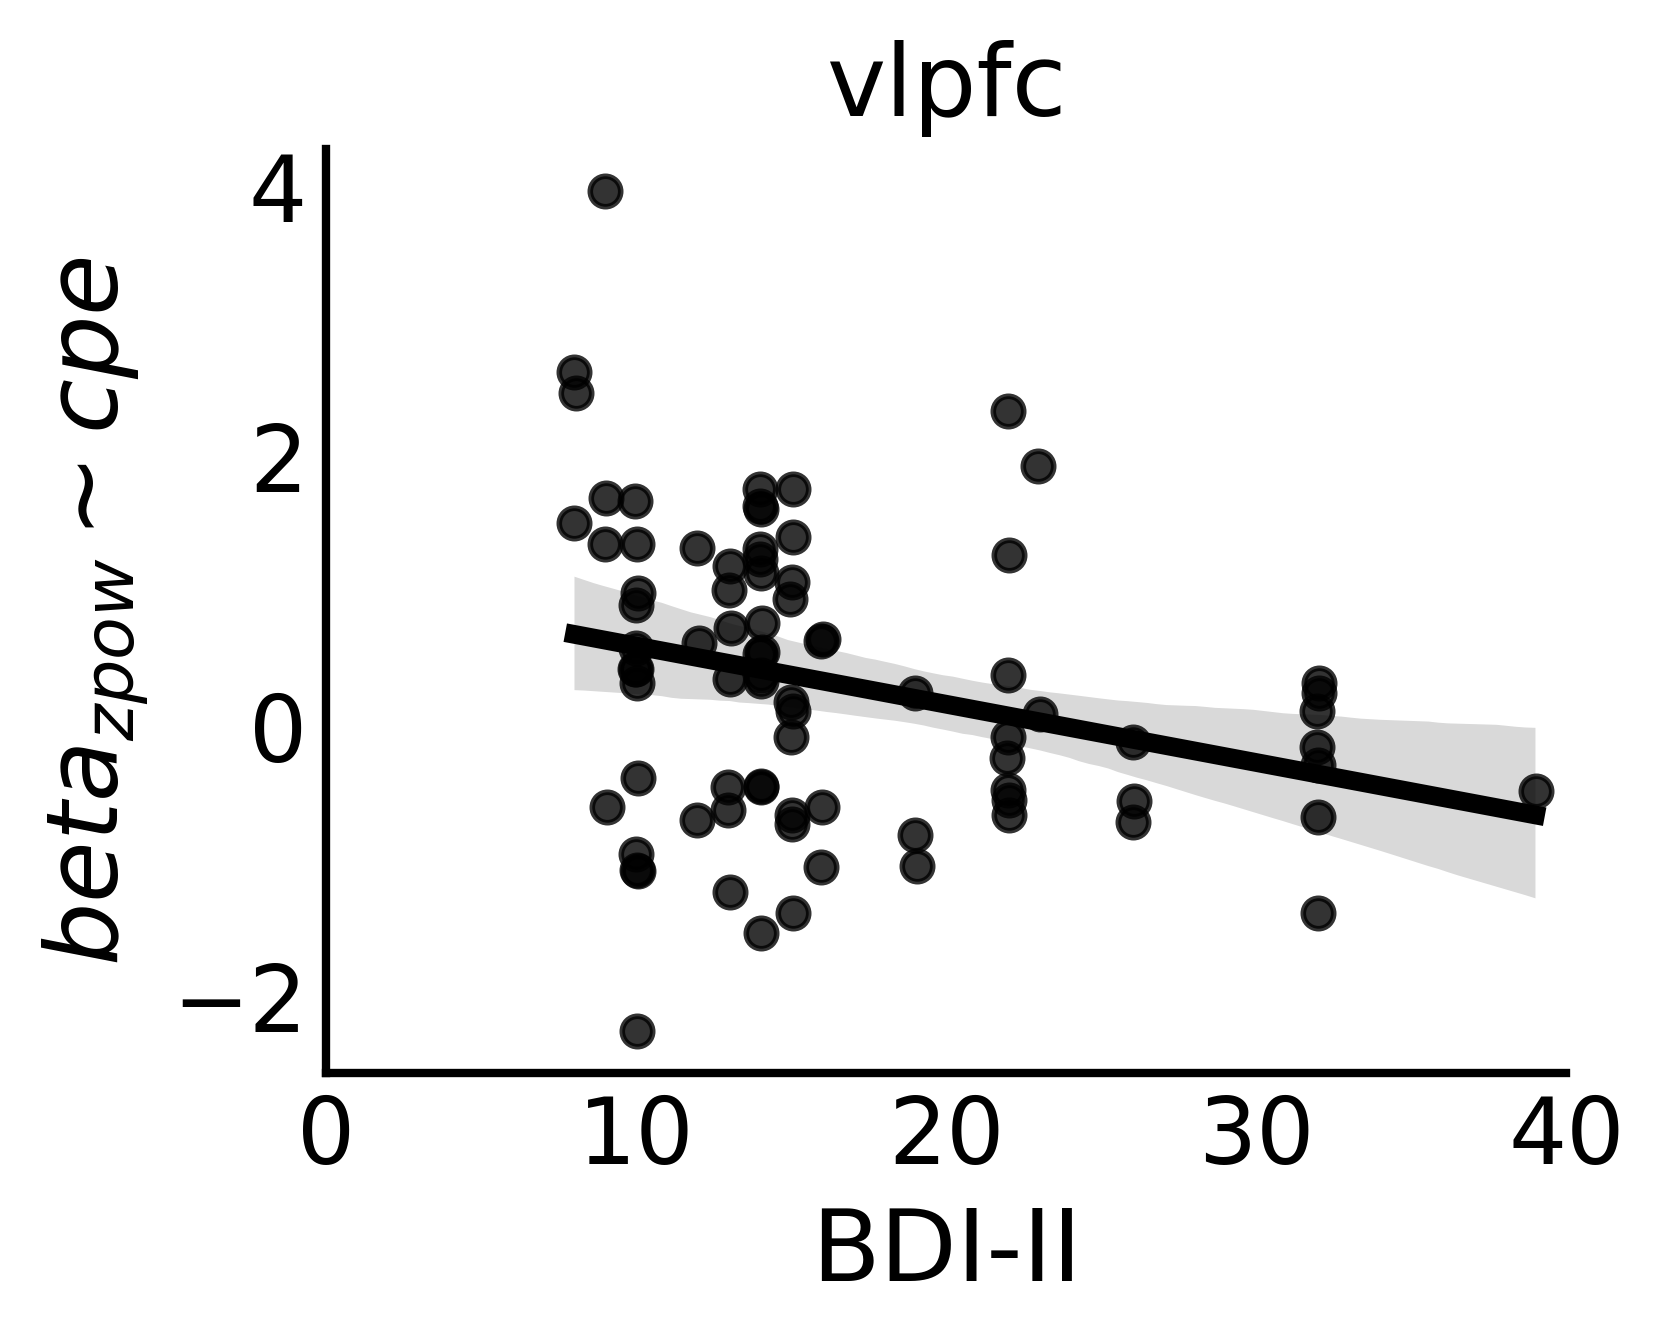

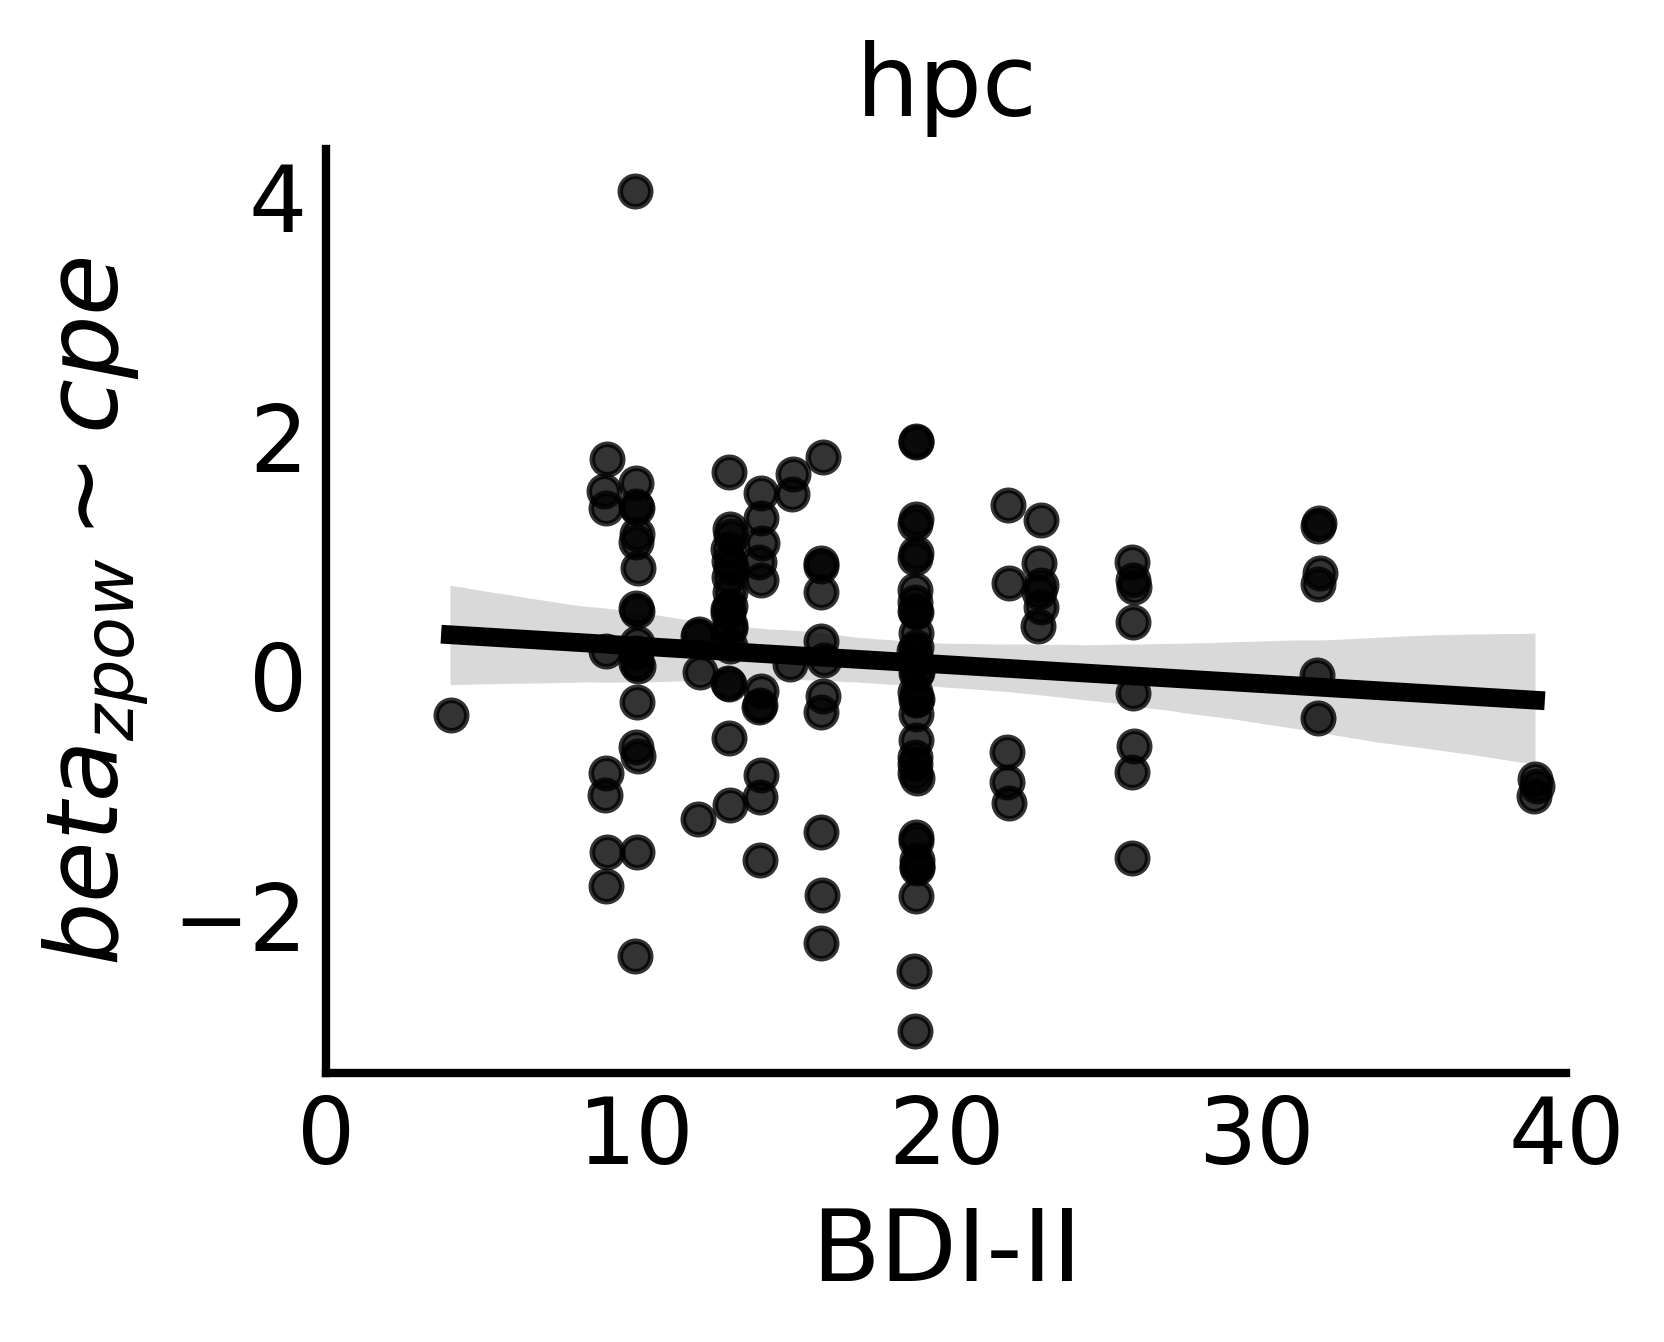

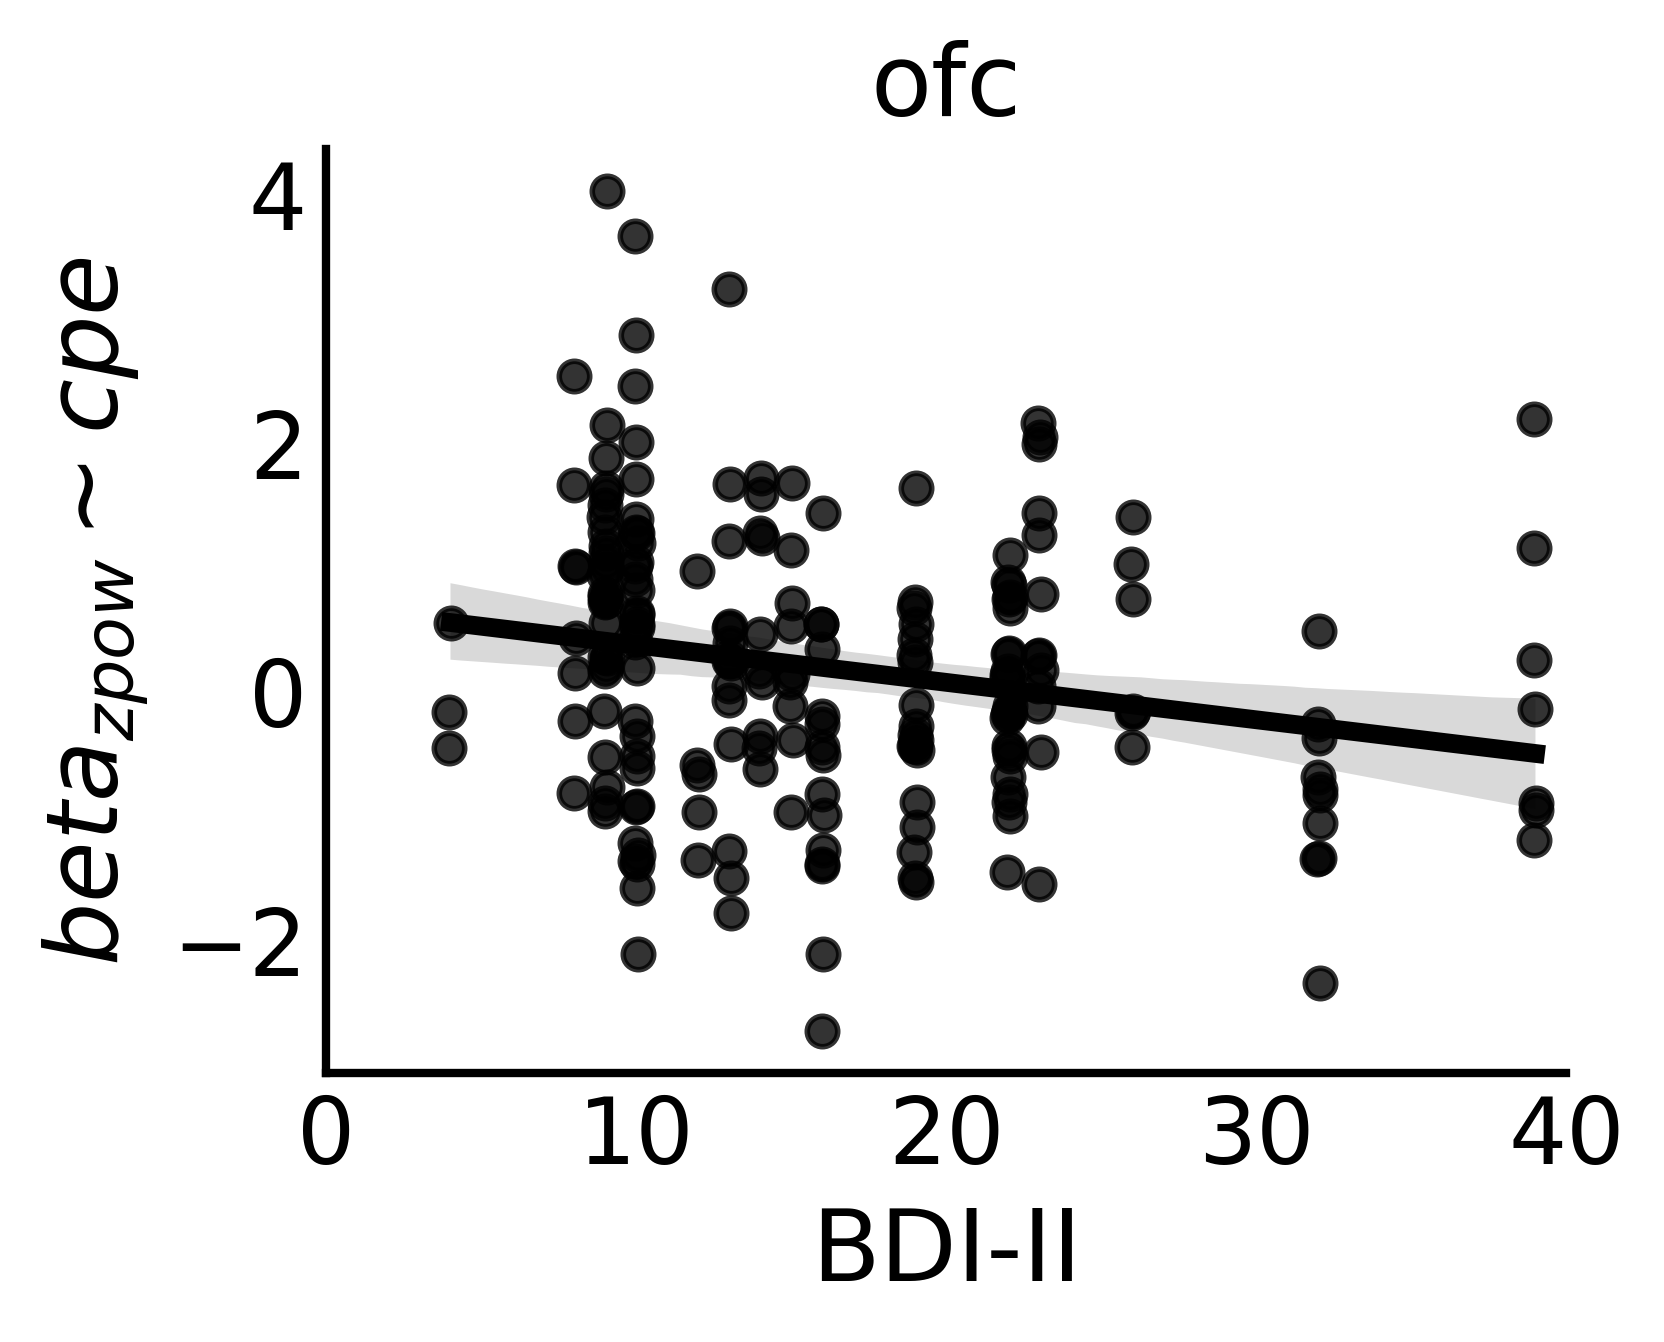

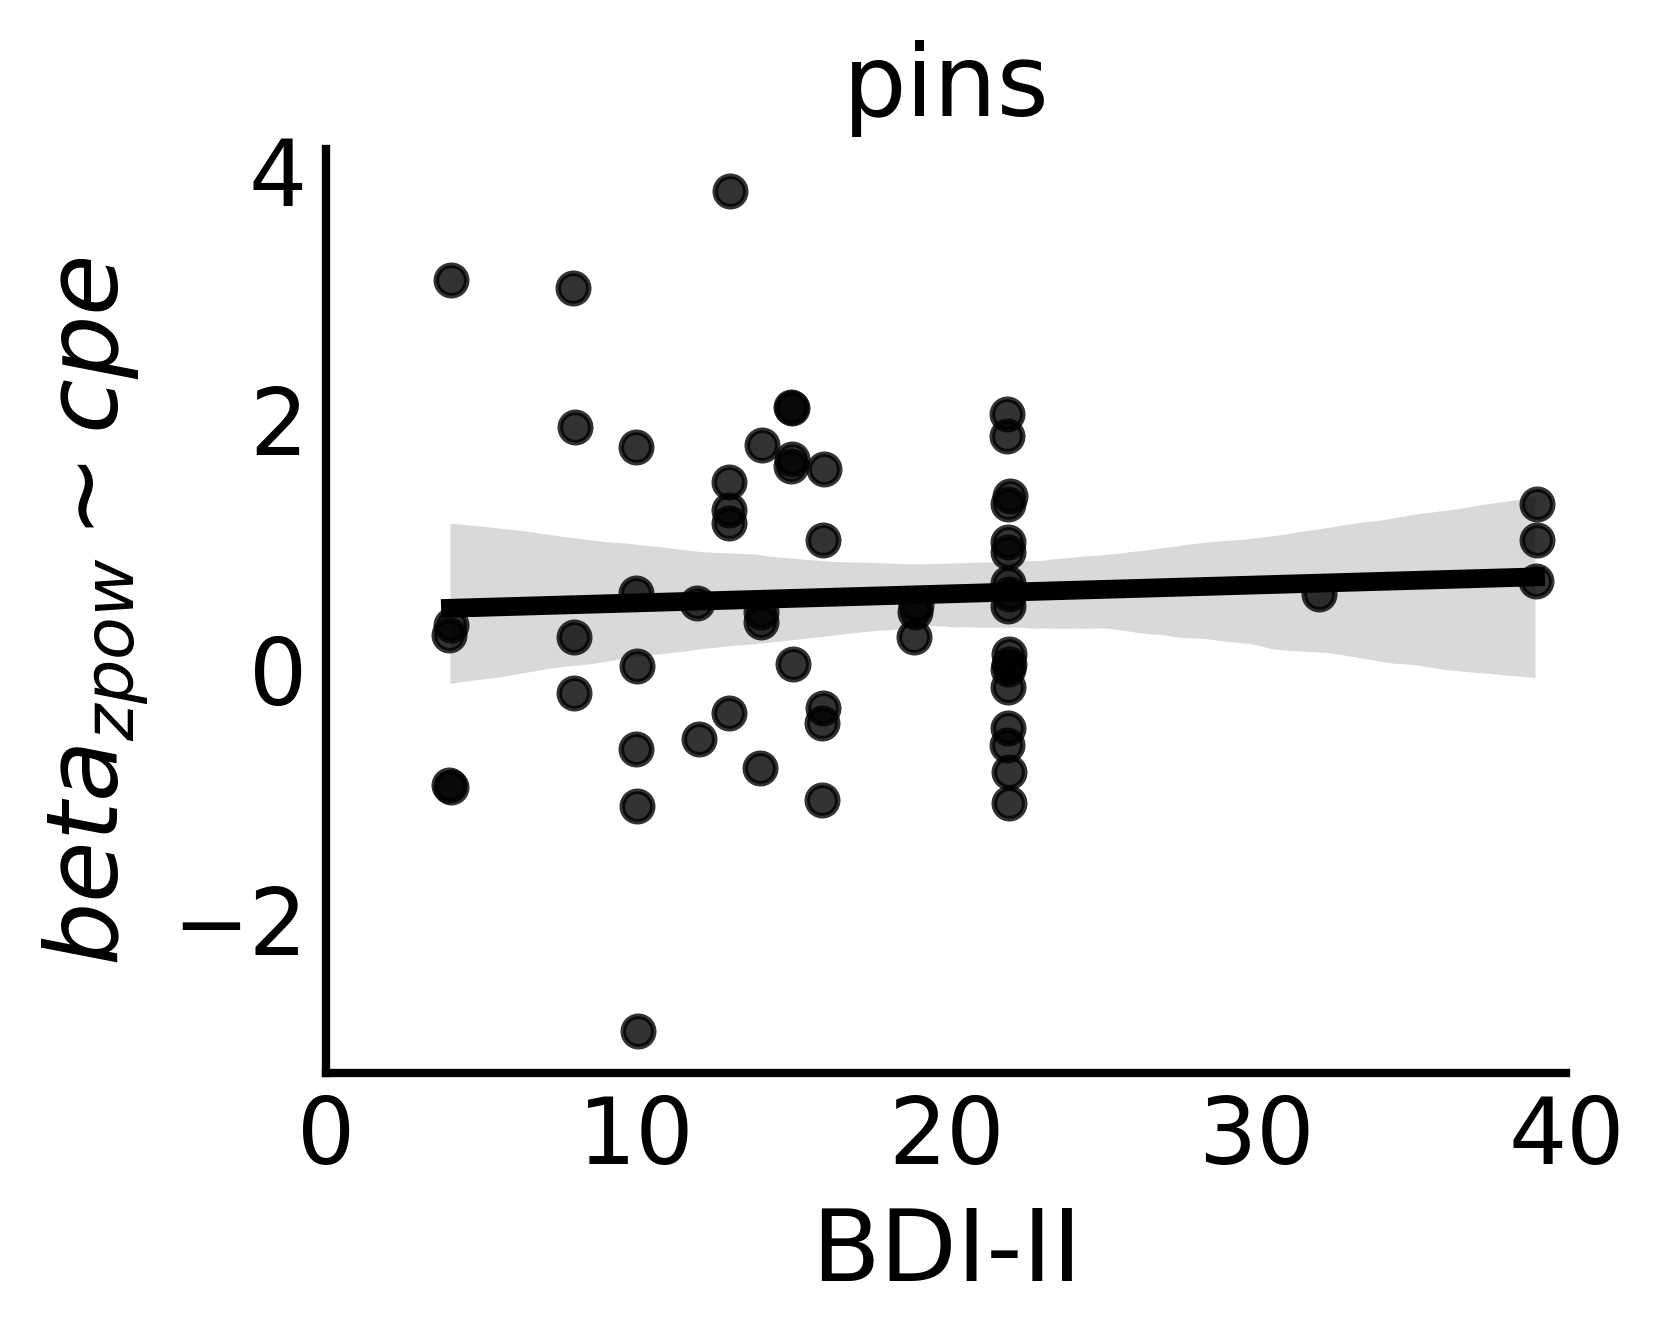

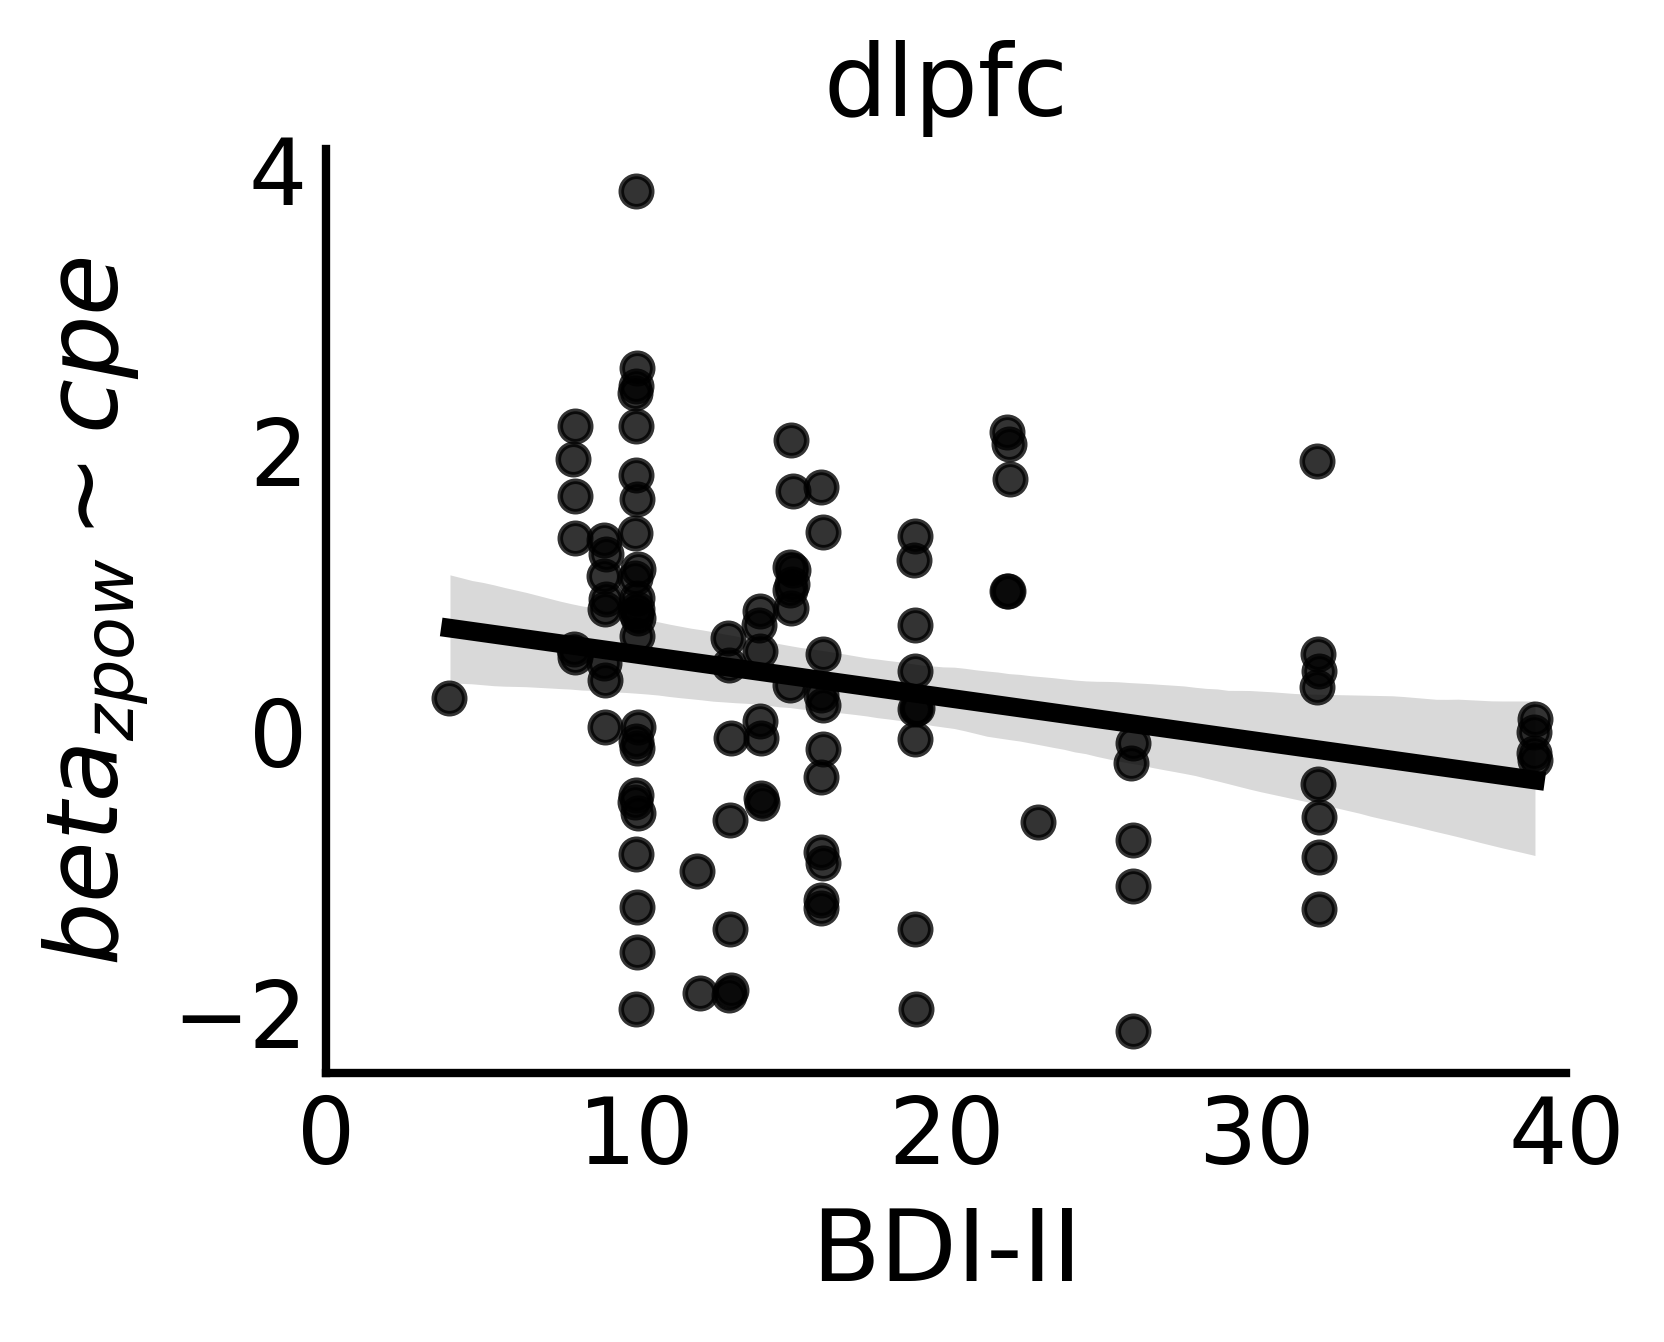

In [43]:
band = 'beta'

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_cpe_coeff_scatter.pdf'
    
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_dir}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [44]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_decisionCPE.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 22 Aug 2024                                         
Time:                        19:41:41                                         
No. Iterations:                    13                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9432      0.447     35.666     

# Mixed effects models

In [47]:
beta_reg_df = beta_df.copy()
beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(bar_order)]
beta_reg_df


,Unnamed: 0,subj_id,bdi,reref_ch_names,unique_reref_ch,epoch,freq,band,band_pow,roi,...,SafeBet,GambleChoice,GambleChoice_t1,TrialEV,Profit,TotalProfit,RPE,decisionCPE,decisionRegret,decisionRelief
0,0,MS002,14,lacas1-lacas2,MS002_lacas1-lacas2,0,20.743342,beta,-0.123971,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
1,1,MS002,14,lacas2-lacas3,MS002_lacas2-lacas3,0,20.743342,beta,-0.186139,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
2,2,MS002,14,lacas3-lacas4,MS002_lacas3-lacas4,0,20.743342,beta,-0.235353,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
3,3,MS002,14,lacas4-lacas5,MS002_lacas4-lacas5,0,20.743342,beta,-0.086471,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
4,4,MS002,14,lacas5-lacas6,MS002_lacas5-lacas6,0,20.743342,beta,-0.145393,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258455,258455,DA039,22,rpins1-rpins2,DA039_rpins1-rpins2,148,20.743342,beta,0.219118,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258456,258456,DA039,22,rpins2-rpins3,DA039_rpins2-rpins3,148,20.743342,beta,0.080566,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258457,258457,DA039,22,rpins3-rpins4,DA039_rpins3-rpins4,148,20.743342,beta,0.204231,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258470,258470,DA039,22,rsgcc6-rsgcc7,DA039_rsgcc6-rsgcc7,148,20.743342,beta,-0.199545,vlpfc,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244


In [48]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
reg_vars     = ['GambleChoice','TotalProfit', 'decisionCPE','roi','hemi','bdi','bdi:decisionCPE']
rand_vars    = ['GambleChoice','TotalProfit', 'decisionCPE']


In [49]:
roi_fit_dict = {f'{roi}':fit_mixed_model(beta_reg_df[beta_reg_df.roi==roi],
                                        reg_vars,rand_vars,outcome_var,rand_eff_var) 
                for roi in beta_reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],beta_reg_df[beta_reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [50]:
roi_fit_results['band'] = 'beta'
# roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats



{'acc': TtestResult(statistic=25.15983042995267, pvalue=1.0790652673721144e-62, df=192),
 'dmpfc': TtestResult(statistic=9.131249482575926, pvalue=4.099914970431354e-17, df=224),
 'amy': TtestResult(statistic=-1.5512443809593819, pvalue=0.12366434870239791, df=112),
 'ains': TtestResult(statistic=38.158698175761174, pvalue=1.3832802599846608e-48, df=70),
 'vlpfc': TtestResult(statistic=28.088613889770517, pvalue=1.6246464794522154e-43, df=81),
 'hpc': TtestResult(statistic=8.378290826945442, pvalue=6.40380913844168e-14, df=134),
 'ofc': TtestResult(statistic=42.04920276078307, pvalue=1.477222334268924e-101, df=201),
 'pins': TtestResult(statistic=8.22890680049308, pvalue=2.2462572082490342e-11, df=59),
 'dlpfc': TtestResult(statistic=15.199177593043716, pvalue=2.209239020246355e-28, df=106)}

In [51]:
# roi_fit_results

fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
fe_results = []
for fe_res in fe_params_results:
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))
    
fe_results = pd.concat(fe_results).reset_index(drop=True)
fe_results['cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]
fe_results['bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi'],4) for roi in fe_results.roi.tolist()]
fe_results['cpe_bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi:decisionCPE'],4) for roi in fe_results.roi.tolist()]

fe_results


,Intercept,GambleChoice[T.safe],hemi[T.r],TotalProfit,decisionCPE,bdi,bdi:decisionCPE,roi,cpe_pval,bdi_pval,cpe_bdi_pval
0,0.007723,-0.013800,0.004556,0.001196,0.017020,-0.000858,-0.000608,acc,0.0043,0.0012,0.0738
1,-0.038989,-0.007179,0.009789,0.010989,0.006907,-0.000202,-0.000040,dmpfc,0.2875,0.7720,0.9129
2,-0.077182,0.008994,0.000278,0.011262,-0.001063,-0.000840,0.000196,amy,0.9330,0.6980,0.7955
3,0.061131,-0.016248,-0.021374,0.009931,0.061766,-0.001848,-0.002251,ains,0.0000,0.0190,0.0053
4,0.003940,-0.013510,-0.010860,0.005658,0.040533,-0.001722,-0.001662,vlpfc,0.0001,0.0383,0.0046
5,-0.188515,0.007712,-0.002708,-0.005739,0.012162,0.003992,-0.000637,hpc,0.3305,0.0705,0.3608
6,0.021404,0.000446,-0.049642,0.004967,0.026380,-0.002604,-0.001190,ofc,0.0000,0.0158,0.0003
7,-0.056432,0.003965,-0.013023,0.002661,0.022169,0.000255,-0.000155,pins,0.0716,0.9036,0.8169
8,-0.030595,-0.010656,0.011508,0.012675,0.026423,-0.001045,-0.000915,dlpfc,0.0013,0.0946,0.0428


In [58]:
fe_results.set_index('roi')

,Intercept,GambleChoice[T.safe],hemi[T.r],TotalProfit,decisionCPE,bdi,bdi:decisionCPE,cpe_pval,bdi_pval,cpe_bdi_pval
roi,,,,,,,,,,
acc,0.007723,-0.013800,0.004556,0.001196,0.017020,-0.000858,-0.000608,0.0043,0.0012,0.0738
dmpfc,-0.038989,-0.007179,0.009789,0.010989,0.006907,-0.000202,-0.000040,0.2875,0.7720,0.9129
amy,-0.077182,0.008994,0.000278,0.011262,-0.001063,-0.000840,0.000196,0.9330,0.6980,0.7955
ains,0.061131,-0.016248,-0.021374,0.009931,0.061766,-0.001848,-0.002251,0.0000,0.0190,0.0053
vlpfc,0.003940,-0.013510,-0.010860,0.005658,0.040533,-0.001722,-0.001662,0.0001,0.0383,0.0046
hpc,-0.188515,0.007712,-0.002708,-0.005739,0.012162,0.003992,-0.000637,0.3305,0.0705,0.3608
ofc,0.021404,0.000446,-0.049642,0.004967,0.026380,-0.002604,-0.001190,0.0000,0.0158,0.0003
pins,-0.056432,0.003965,-0.013023,0.002661,0.022169,0.000255,-0.000155,0.0716,0.9036,0.8169
dlpfc,-0.030595,-0.010656,0.011508,0.012675,0.026423,-0.001045,-0.000915,0.0013,0.0946,0.0428


In [52]:
bonferr_alpha = 0.05/len(fe_results)
# bonferr_alpha = 0.01

bonferr_alpha



0.005555555555555556

In [53]:
sig_cpe_rois = fe_results.roi[fe_results.cpe_pval <= bonferr_alpha].tolist()
sig_cpe_rois



['acc', 'ains', 'vlpfc', 'ofc', 'dlpfc']

In [59]:
sig_cpe_bdi_rois = fe_results.roi[fe_results.cpe_bdi_pval <= bonferr_alpha].tolist()
sig_cpe_bdi_rois



['ains', 'vlpfc', 'ofc']

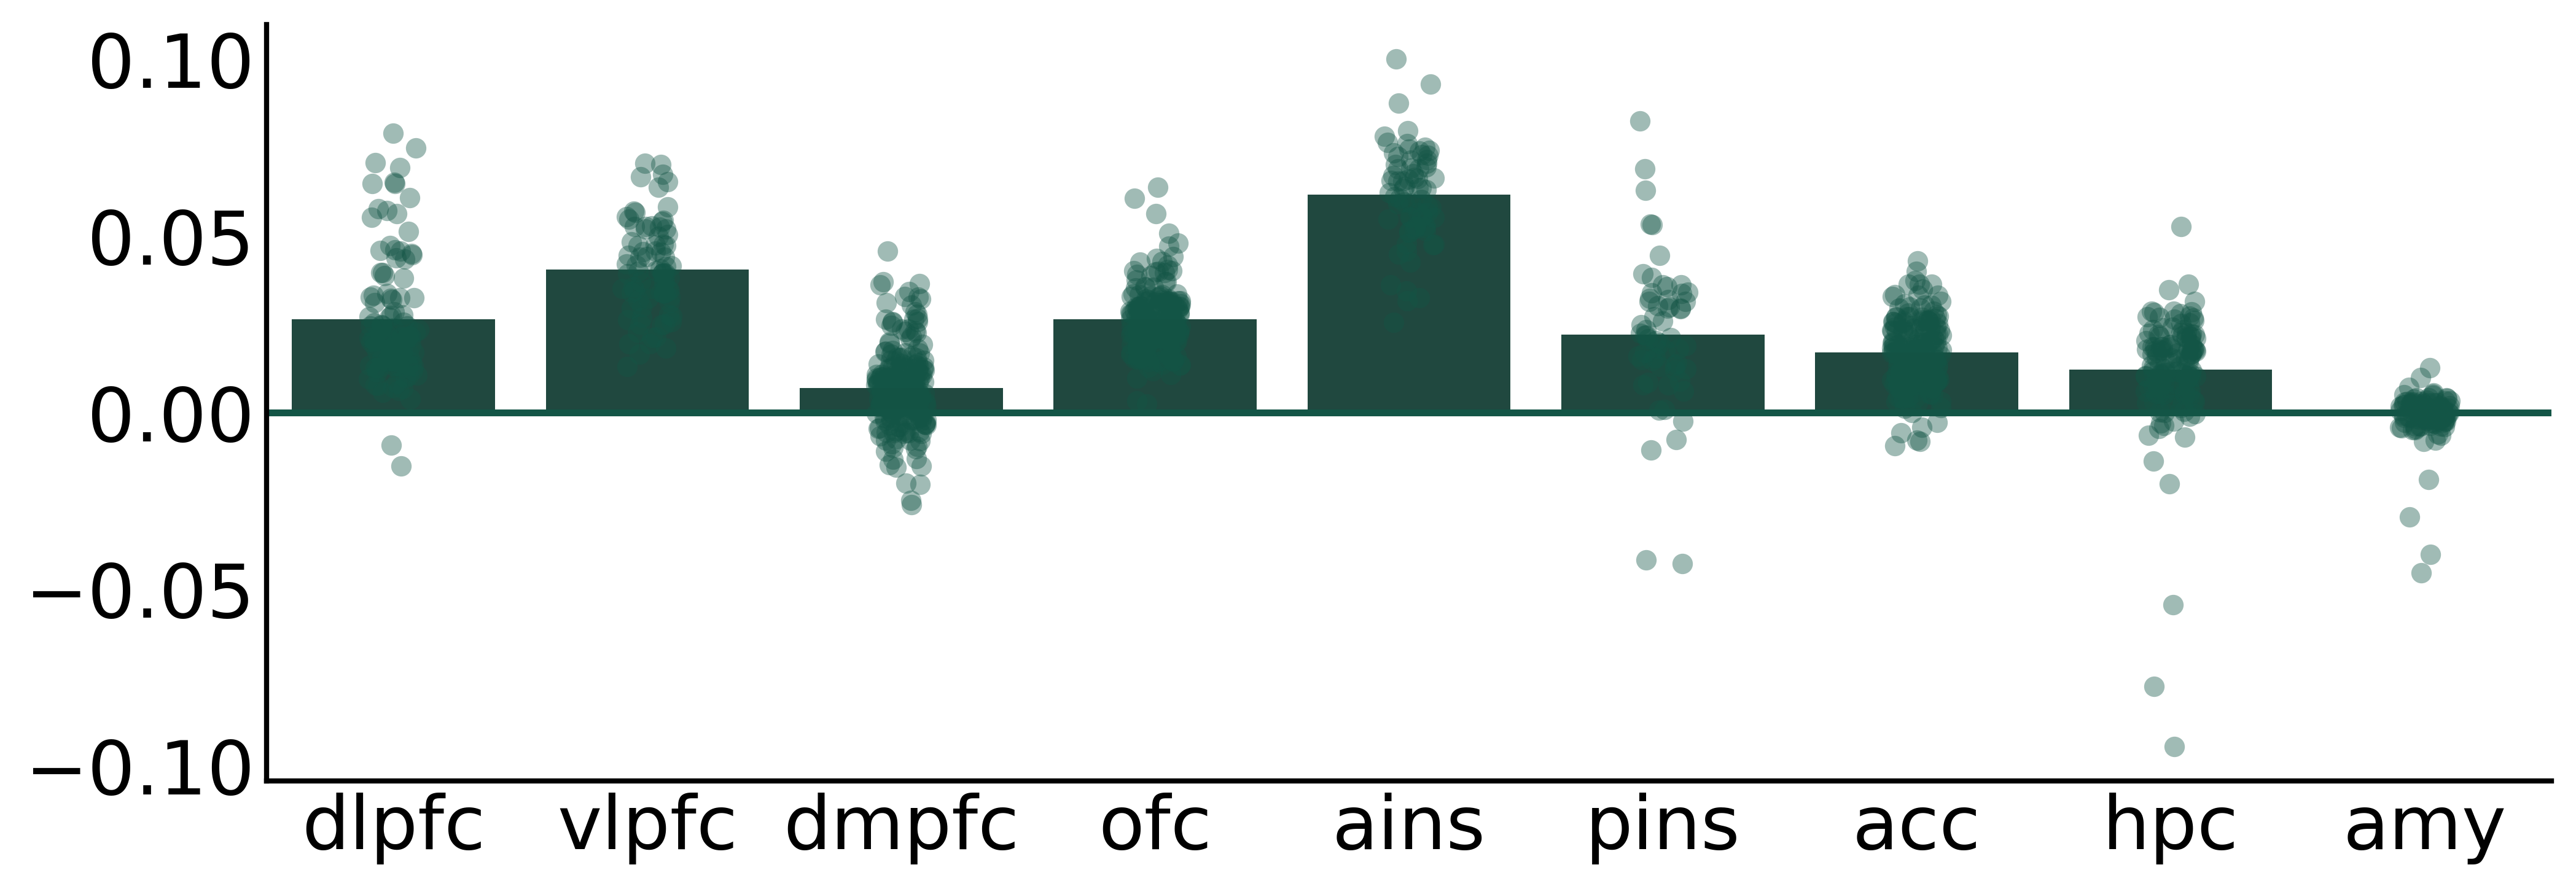

In [55]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=bar_order,figsize=(12,4),color='#135546')



In [56]:
# plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=sig_rois,color='#135546')


# # plot ROI beta distribution
# sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# plt.title(f'ACC n={n}')
# sns.despine()


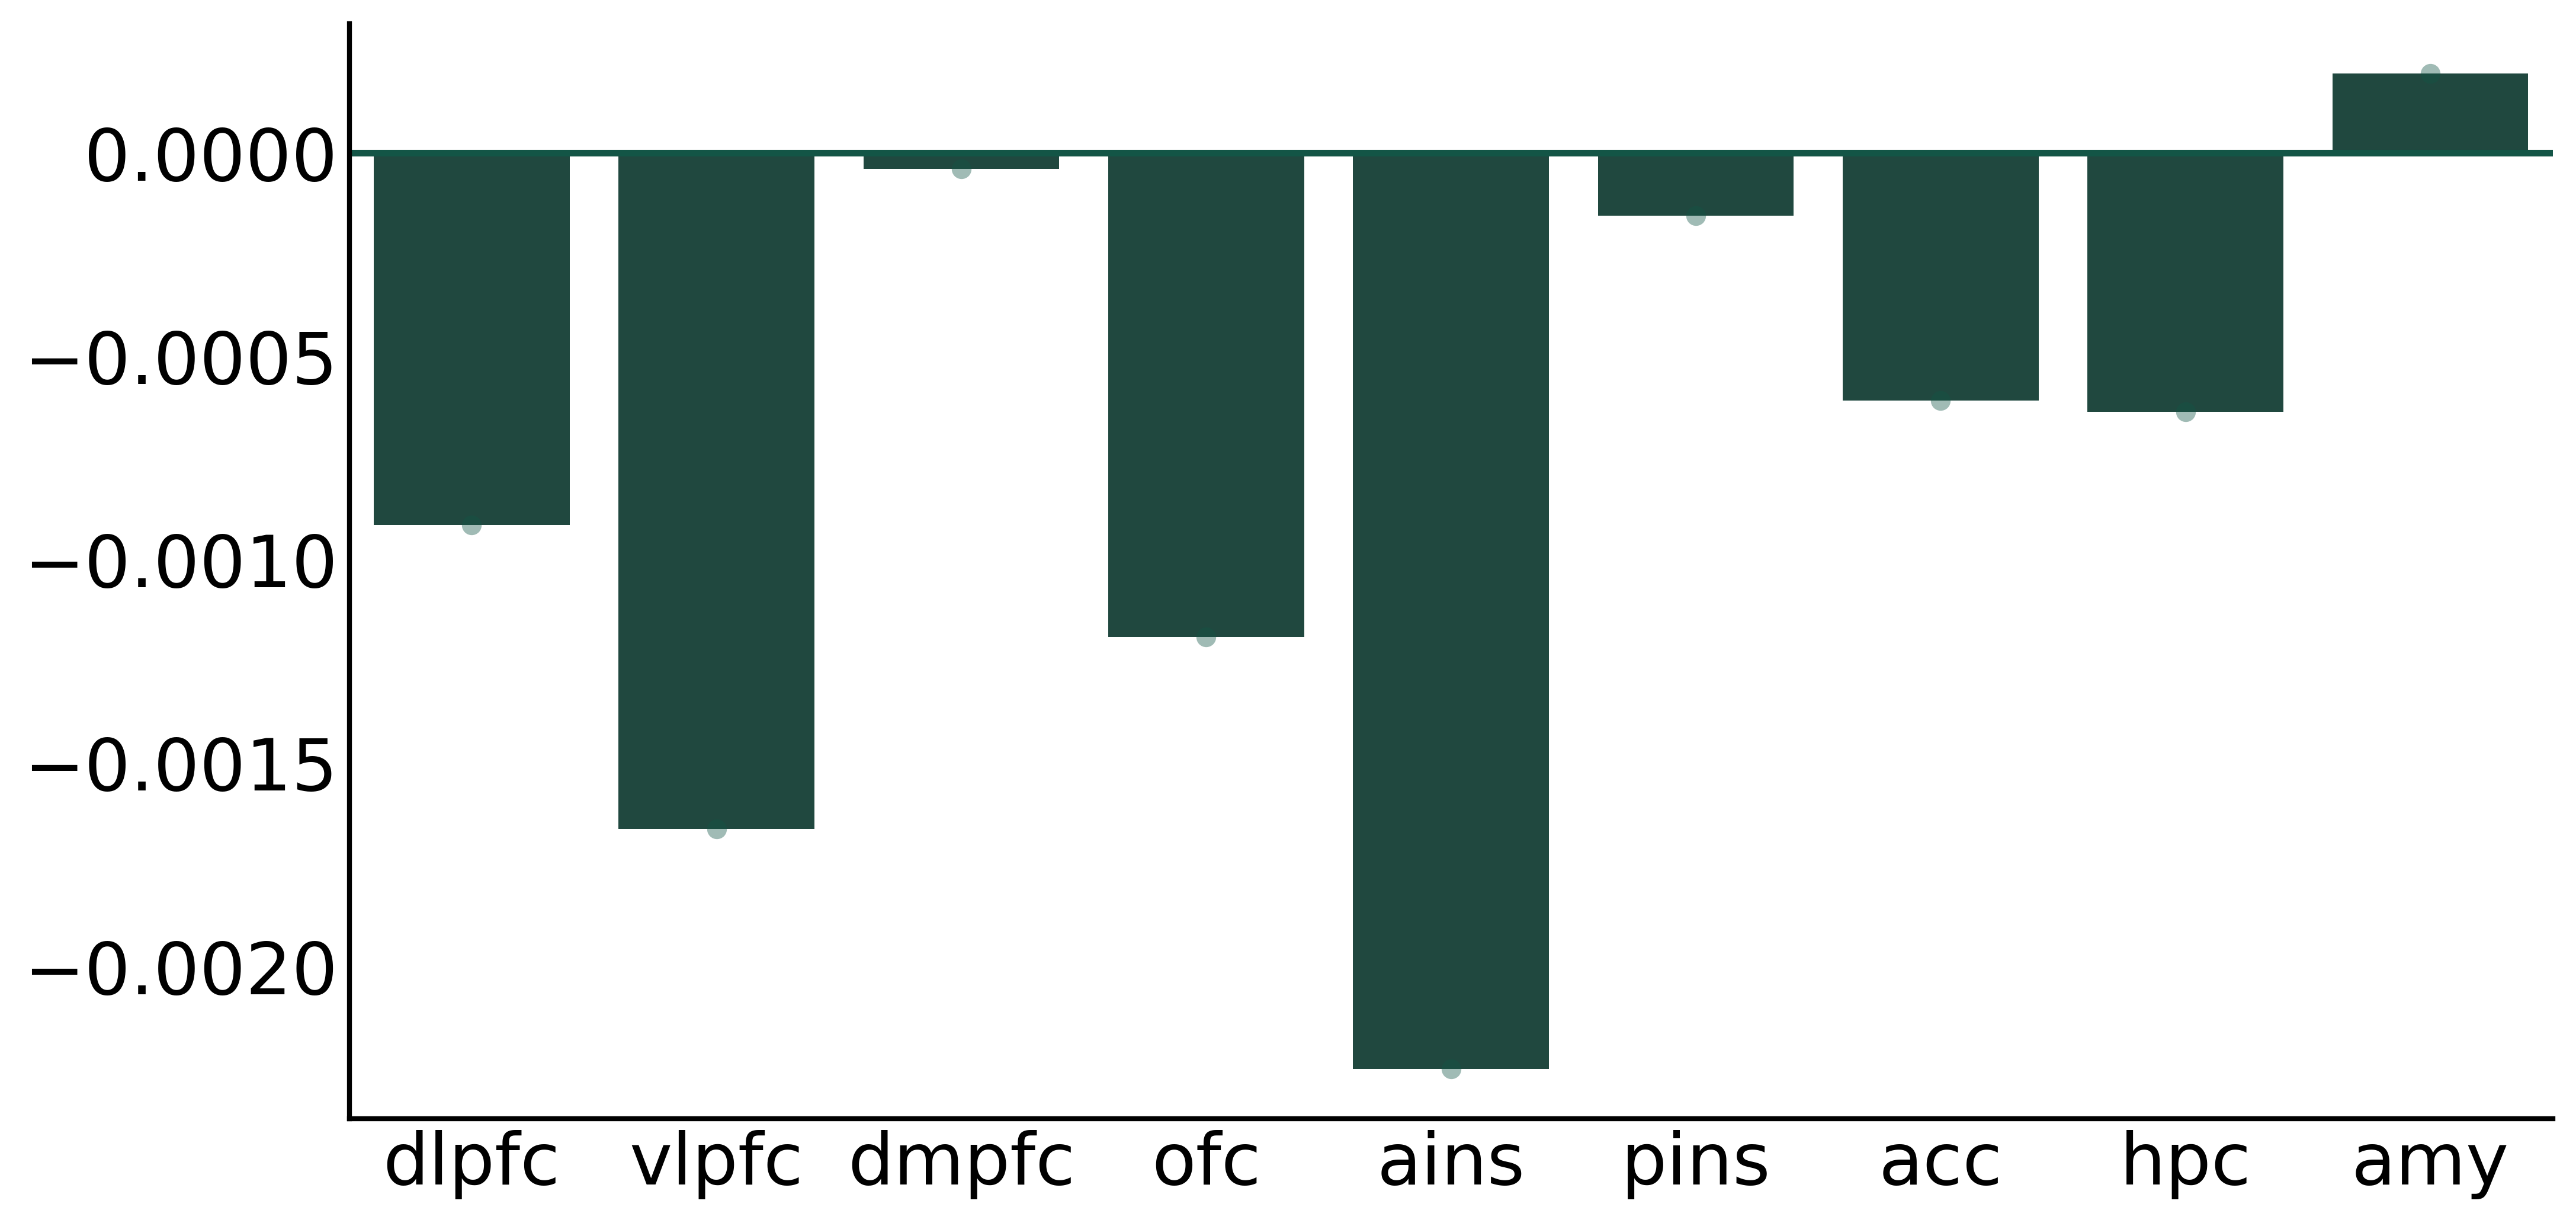

In [57]:
plot_roi_model_results(fe_results,'roi',"bdi:decisionCPE",bar_order=bar_order,figsize=(12,6),color='#135546')
# add to slides 
